/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/ipykernel_20516/3829852387.py:42: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data_full = heatmap_data_full.pivot('Setting_Variant', 'Application', 'Relative Performance')


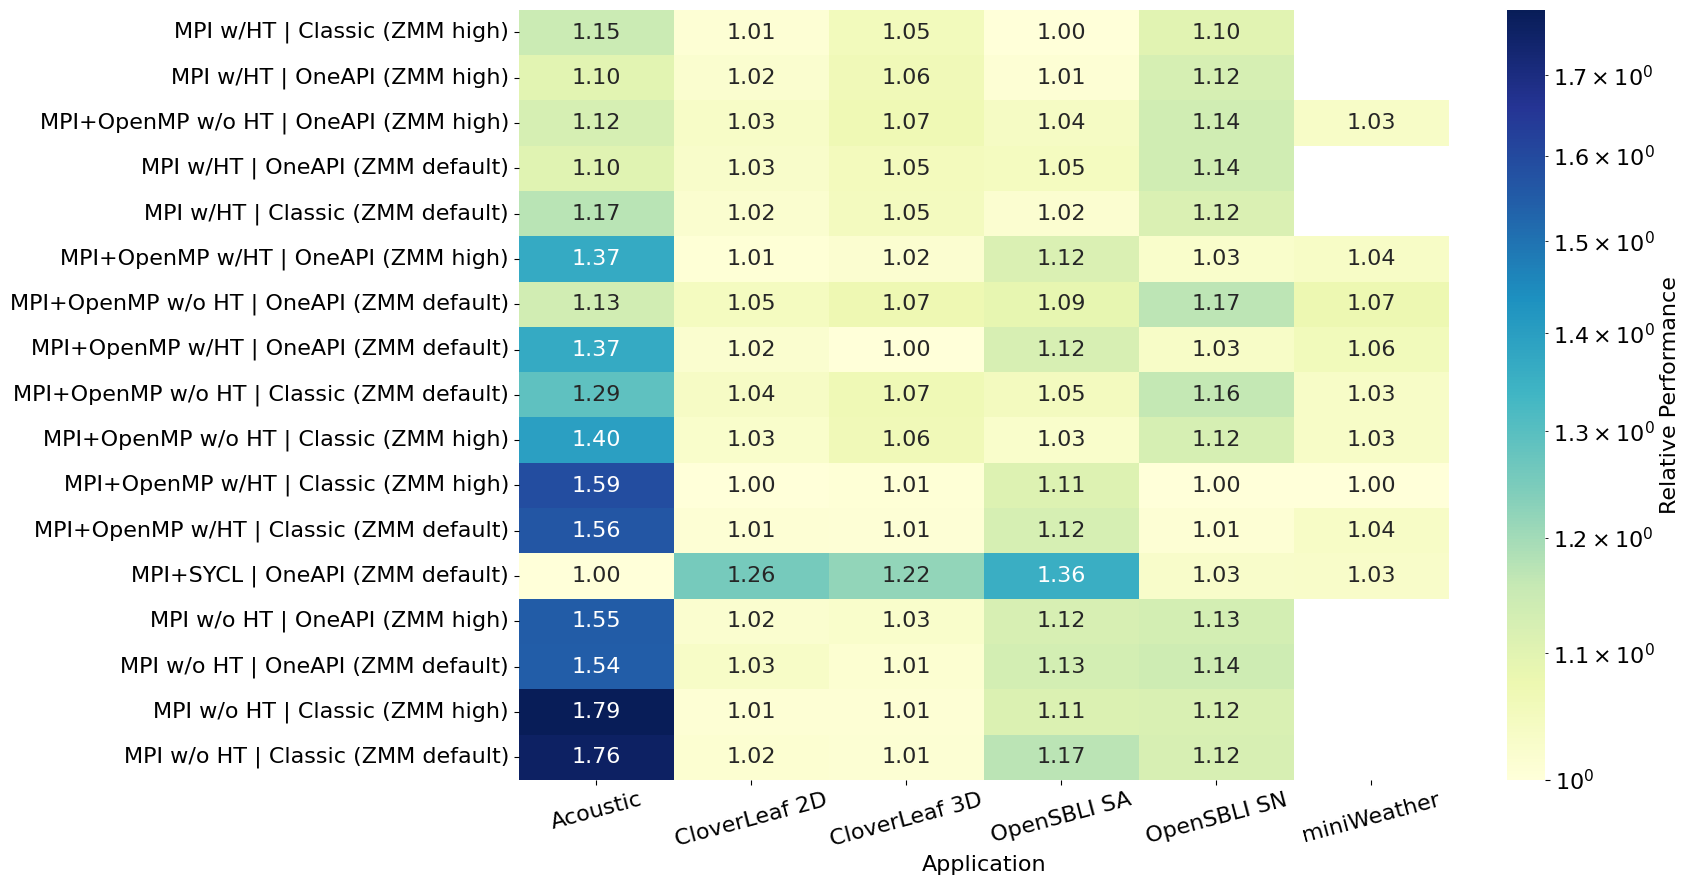

1.1112667271425722
1.0560541141432864


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import pandas as pd
import numpy as np

# Load the data from the provided Excel file
data = pd.read_excel("test1ICX.xlsx")

# Clean the data and set the proper headers
data.columns = ['Application', 'Variant', 'Classic (ZMM default)', 'Classic (ZMM high)', 'OneAPI (ZMM default)', 'OneAPI (ZMM high)']
data = data.iloc[1:]  # Remove the first row (headers)
data.reset_index(drop=True, inplace=True)


# Fill missing values in the 'Application' column
data['Application'].fillna(method='ffill', inplace=True)

# Convert runtime columns to numeric values
for col in ['Classic (ZMM default)', 'Classic (ZMM high)', 'OneAPI (ZMM default)', 'OneAPI (ZMM high)']:
    data[col] = pd.to_numeric(data[col], errors='coerce')


# Calculate the best runtime for each application
best_runtime_per_application = data.groupby('Application')[['Classic (ZMM default)', 'Classic (ZMM high)', 'OneAPI (ZMM default)', 'OneAPI (ZMM high)']].min().min(axis=1)

# Initialize a dataframe to store the relative performance of each variant compared to the best runtime for each application
relative_performance_best = data.copy()

# Calculate the relative performance for each application
for app in data['Application'].unique():
    for col in ['Classic (ZMM default)', 'Classic (ZMM high)', 'OneAPI (ZMM default)', 'OneAPI (ZMM high)']:
        relative_performance_best.loc[relative_performance_best['Application'] == app, col] /= best_runtime_per_application[app]

# Create a pivot table for the heatmap
heatmap_data = relative_performance_best.groupby(['Application', 'Variant']).mean().mean(axis=1).unstack()


# Create a pivot table for the heatmap
heatmap_data_full = relative_performance_best.melt(id_vars=['Application', 'Variant'], value_vars=['Classic (ZMM default)', 'Classic (ZMM high)', 'OneAPI (ZMM default)', 'OneAPI (ZMM high)'], var_name='Setting', value_name='Relative Performance')
heatmap_data_full['Setting_Variant'] = heatmap_data_full['Variant'] + ' | ' + heatmap_data_full['Setting']
heatmap_data_full = heatmap_data_full.pivot('Setting_Variant', 'Application', 'Relative Performance')


# Remove rows with all NaN values and specified applications
heatmap_data_full_filtered = heatmap_data_full.dropna(how='all')
heatmap_data_full_filtered = heatmap_data_full_filtered.drop(columns=['MG-CFD', 'Volna'])

# Order the rows in ascending order by their average
heatmap_data_full_filtered['Average'] = heatmap_data_full_filtered.mean(axis=1)
heatmap_data_full_filtered = heatmap_data_full_filtered.sort_values(by='Average')
del heatmap_data_full_filtered['Average']

# Remove rows with all NaN values
heatmap_data_full_filtered = heatmap_data_full_filtered.dropna(how='all')


# Create the heatmap with logarithmic color scale but original values
plt.figure(figsize=(15, 10))
sns.heatmap(heatmap_data_full_filtered, annot=heatmap_data_full_filtered, cmap="YlGnBu", norm=colors.LogNorm(), cbar_kws={'label': 'Relative Performance'}, fmt=".2f")
# plt.title('Heatmap of Relative Performance vs. Best Combination for Each Application (Filtered with Logarithmic Color Scale)')
plt.xticks(rotation=15)
plt.savefig('heatmap_structured.pdf', format='pdf', bbox_inches = 'tight')
plt.ylabel('')
plt.show()

print(heatmap_data_full_filtered.mean().mean())
print(np.nanmedian(heatmap_data_full_filtered.values.flatten()))
#print(heatmap_data_full_filtered.values.flatten())


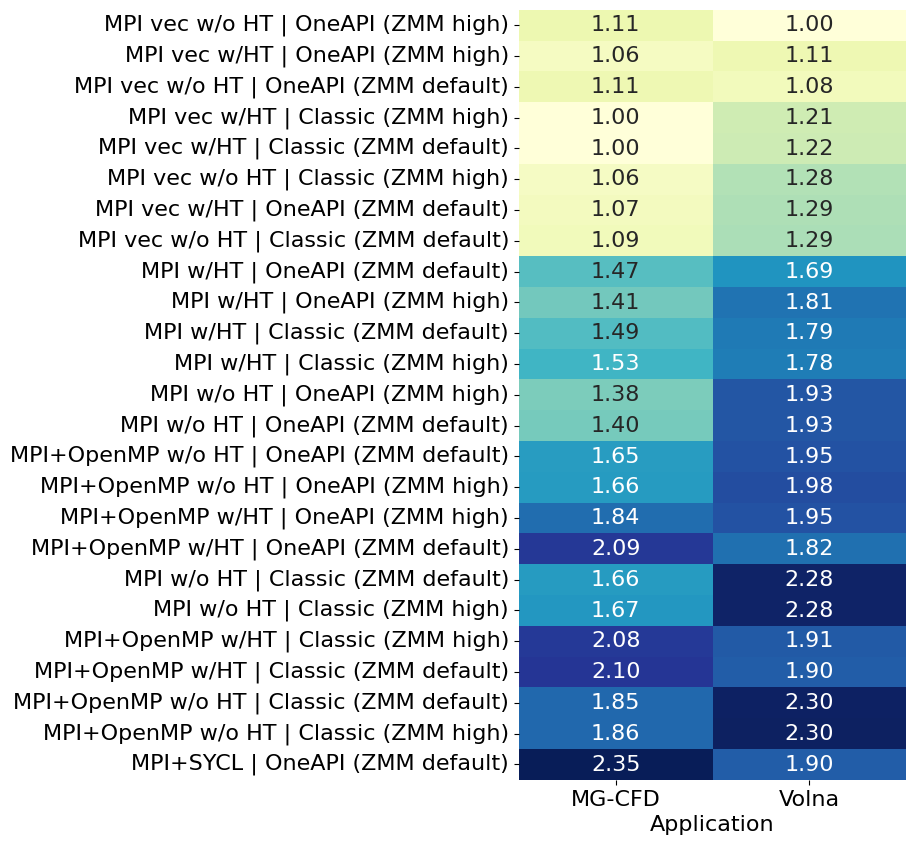

In [52]:
# Remove rows with all NaN values and specified applications
heatmap_data_full_filtered = heatmap_data_full.dropna(how='all')
heatmap_data_full_filtered = heatmap_data_full_filtered.drop(columns=['Acoustic', 'CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SA', 'OpenSBLI SN', 'miniWeather'])

# Order the rows in ascending order by their average
heatmap_data_full_filtered['Average'] = heatmap_data_full_filtered.mean(axis=1)
heatmap_data_full_filtered = heatmap_data_full_filtered.sort_values(by='Average')
del heatmap_data_full_filtered['Average']

# Remove rows with all NaN values
heatmap_data_full_filtered = heatmap_data_full_filtered.dropna(how='all')


# Create the heatmap with logarithmic color scale but original values
plt.figure(figsize=(5, 10))
sns.heatmap(heatmap_data_full_filtered, annot=heatmap_data_full_filtered, cmap="YlGnBu", norm=colors.LogNorm(),  fmt=".2f",cbar=False)
# plt.title('Heatmap of Relative Performance vs. Best Combination for Each Application (Filtered with Logarithmic Color Scale)')
plt.ylabel('')
plt.savefig('heatmap_unstructured.pdf', format='pdf',bbox_inches = 'tight')
plt.show()

In [91]:
# Filter data for MPI+OpenMP variant for Volna and MG-CFD
data_MPI_OpenMP = data[(data['Variant'].str.contains('MPI w/HT')) & (data['Application'].isin(['Volna', 'MG-CFD']))]

# Filter data for non-vectorizing MPI variants for Volna and MG-CFD
data_MPI_non_vec = data[(data['Variant'].str.contains('MPI w/o HT') & ~data['Variant'].str.contains('vec')) & (data['Application'].isin(['Volna', 'MG-CFD']))]

# Calculate average runtime for each variant
avg_runtime_MPI_OpenMP = data_MPI_OpenMP[['Classic ICC/ICPC (ZMM default)', 'Classic ICC/ICPC (ZMM high)', 'ICX/ICPX (ZMM default)', 'ICX/ICPX (ZMM high)']].mean().mean()
avg_runtime_MPI_non_vec = data_MPI_non_vec[['Classic ICC/ICPC (ZMM default)', 'Classic ICC/ICPC (ZMM high)', 'ICX/ICPX (ZMM default)', 'ICX/ICPX (ZMM high)']].mean().mean()

# Calculate the average difference
avg_diff_MPI_OpenMP_non_vec = avg_runtime_MPI_non_vec/ avg_runtime_MPI_OpenMP

avg_diff_MPI_OpenMP_non_vec

1.1749992877178796

In [93]:
import pandas as pd

app = "miniWeather"
# app = "RTM"

# Load the spreadsheet
xlsx = pd.ExcelFile('summary_results.xlsx')

# Get all sheet names
sheet_names = xlsx.sheet_names

# Read all sheets into a dictionary of dataframes
dfs = {sheet_name: pd.read_excel(xlsx, sheet_name) for sheet_name in sheet_names}

# Filter data for "CloverLeaf 2D" and create a new DataFrame for plotting
cloverleaf_data = pd.DataFrame()

for hardware in sheet_names:
    df = dfs[hardware]
    cloverleaf_row = df[df[df.columns[0]] == app]
    cloverleaf_row["Hardware"] = hardware
    cloverleaf_data = pd.concat([cloverleaf_data, cloverleaf_row])

# Reset index for the new DataFrame
cloverleaf_data.reset_index(drop=True, inplace=True)

# Melt the DataFrame to make it suitable for a grouped bar plot
cloverleaf_melt = cloverleaf_data.melt(id_vars=["Hardware"], var_name="Implementation", value_name="Runtime")


# Remove rows with NaN values
cloverleaf_melt = cloverleaf_melt.dropna()

# Remove the rows where Runtime is "CloverLeaf 2D" - these are not numerical values
cloverleaf_melt = cloverleaf_melt[cloverleaf_melt["Runtime"] != app]

# Convert Runtime to float for plotting
cloverleaf_melt["Runtime"] = cloverleaf_melt["Runtime"].astype(float)


## slowdown table
# Calculate the minimum runtime
min_runtime = cloverleaf_melt["Runtime"].min()

# Calculate slowdown multipliers and add to the DataFrame
cloverleaf_melt["Slowdown Multiplier"] = cloverleaf_melt["Runtime"] / min_runtime

# Pivot the DataFrame to create a table
slowdown_table = cloverleaf_melt.pivot_table(values='Slowdown Multiplier', index='Hardware', columns='Implementation')
slowdown_table = slowdown_table.reindex(["SPR", "ICX", "MilanX"])



/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/ipykernel_3568/405862312.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/ipykernel_3568/405862312.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/ipykernel_3568/405862312.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 16})

# Create a color palette with more distinguishable colors
palette = sns.color_palette("hsv", len(cloverleaf_melt["Hardware"].unique()))

# Adjust figure size and layout to remove empty spaces
fig, axs = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 0.3]})

# Create the bar plot in the first subplot
sns.barplot(x='Implementation', y='Runtime', hue='Hardware', data=cloverleaf_melt, ax=axs[0], ci=None, palette=palette)
axs[0].set_title(f'Runtime of "{app}" on Different Implementations and Hardware')
axs[0].set_ylabel('Runtime (seconds)')

# Add data labels to the bar plot
for p in axs[0].patches:
    axs[0].annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

# Create the table in the second subplot
axs[1].axis('off')  # Hide plot axis
table = axs[1].table(cellText=np.round(slowdown_table.values, 2), 
                     colLabels=slowdown_table.columns, 
                     rowLabels=slowdown_table.index, 
                     cellLoc='center', 
                     loc='center')

# Improve table appearance
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(1, 1.5)
axs[1].set_title('Slowdown Multipliers Compared to Lowest Runtime')

plt.tight_layout()
plt.show()

NameError: name 'cloverleaf_melt' is not defined

/var/folders/3d/k50p2kcd7z3_lx403czyn3pm0000gn/T/ipykernel_20516/3966831155.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=spr_data.columns[0], y='Relative Performance', hue='Implementation', data=relative_spr_melt, ci=None)


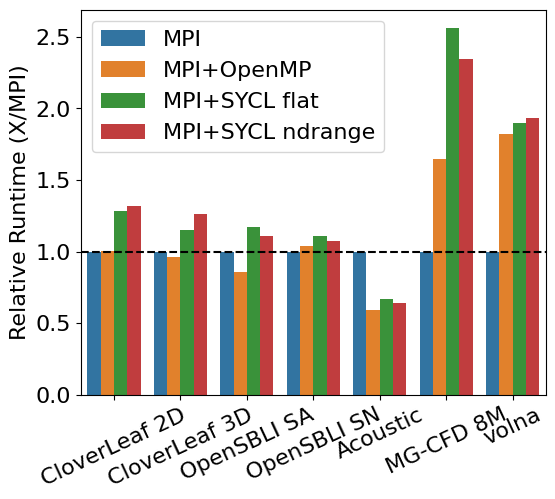

In [80]:
# Select the SPR data
spr_data = dfs["SPR"]

# Calculate the minimum runtime for each application (which is the MPI implementation)
mpi_runtimes = spr_data.set_index(spr_data.columns[0])["MPI"]

# Divide all runtimes by the MPI runtime to get relative performance
relative_spr_data = spr_data.set_index(spr_data.columns[0]).divide(mpi_runtimes, axis=0).reset_index()

# Melt the DataFrame to make it suitable for a grouped bar plot
relative_spr_melt = relative_spr_data.melt(id_vars=relative_spr_data.columns[0], var_name="Implementation", value_name="Relative Performance")


# Drop rows corresponding to miniWeather and miniBUDE
relative_spr_melt = relative_spr_melt[~relative_spr_melt[spr_data.columns[0]].isin(['miniWeather', 'miniBUDE'])]

plt.figure(figsize=(6, 5))
plt.axhline(1, color='black', linestyle='--')  # Add horizontal line at y=1

sns.barplot(x=spr_data.columns[0], y='Relative Performance', hue='Implementation', data=relative_spr_melt, ci=None)
# plt.set_xticklabels(spr_data.index, rotation=15)
plt.xticks(rotation=25)
plt.xlabel('')

plt.ylabel('Relative Runtime (X/MPI)')
# plt.title('Relative Performance of Parallelizations vs. MPI - higher than 1.0 is slower')
plt.legend(loc='upper left')
plt.savefig('relative_to_mpi.pdf', format='pdf',bbox_inches = 'tight')
plt.show()

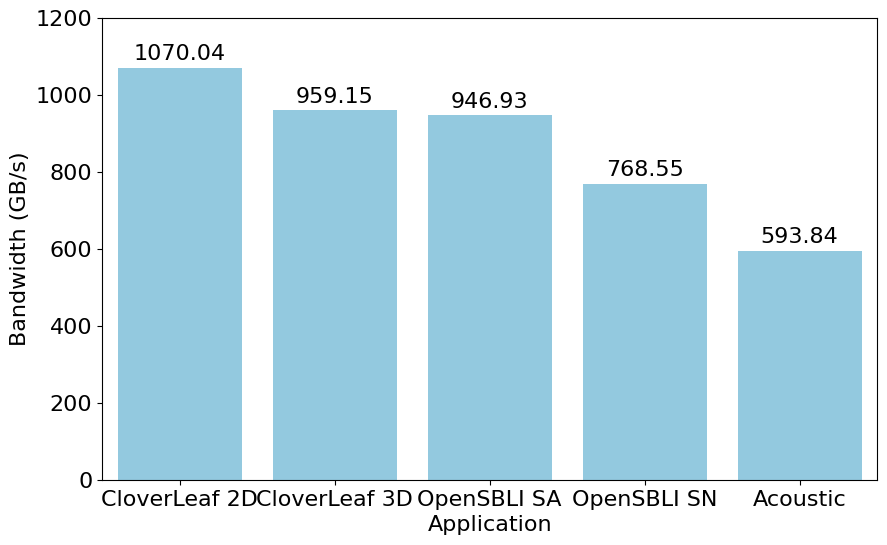

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the bandwidth figures
bandwidth_data = pd.DataFrame({
    'Application': ['CloverLeaf 2D', 'CloverLeaf 3D', 'OpenSBLI SA', 'OpenSBLI SN', 'Acoustic'],
    'Bandwidth (GB/s)': [1070.036533, 959.1459782, 946.9293528, 768.5525911, 593.8411389]
})

# Create a bar plot
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Application', y='Bandwidth (GB/s)', data=bandwidth_data, color='skyblue')

# Add data labels
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.2f'),
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

plt.ylabel('Bandwidth (GB/s)')
bar_plot.set_ylim(0, 1200)
# plt.title('Achieved Effective Bandwidth on Different Applications on Xeon MAX CPU')
plt.savefig('achieved_bandwidth.pdf', format='pdf',bbox_inches = 'tight')
plt.show()

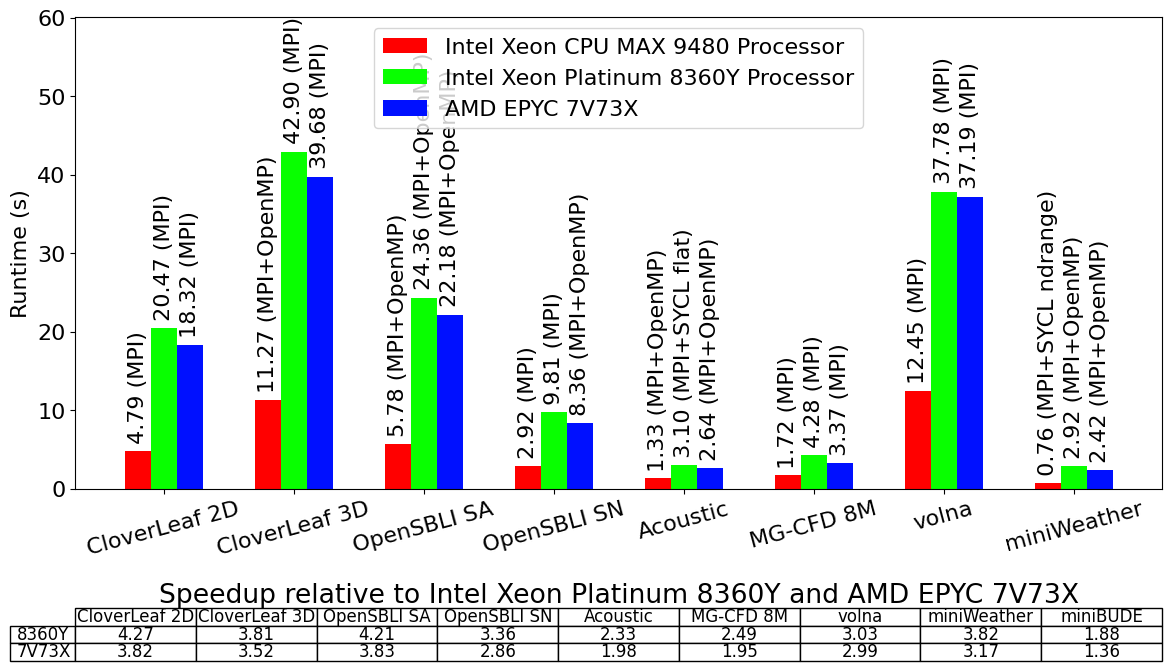

In [39]:
import pandas as pd

# Load the Excel file
xls = pd.ExcelFile('summary_results.xlsx')

df_SPR = pd.read_excel(xls, 'SPR')
df_ICX = pd.read_excel(xls, 'ICX')
df_MilanX = pd.read_excel(xls, 'MilanX')

#Correct the dataframes by renaming the first column to "Application"
df_SPR.rename(columns={df_SPR.columns[0]: "Application"}, inplace=True)
df_ICX.rename(columns={df_ICX.columns[0]: "Application"}, inplace=True)
df_MilanX.rename(columns={df_MilanX.columns[0]: "Application"}, inplace=True)
df_SPR.replace('RTM', 'Acoustic', inplace=True)
df_ICX.replace('RTM', 'Acoustic', inplace=True)
df_MilanX.replace('RTM', 'Acoustic', inplace=True)

# Update the dictionary with the corrected dataframes
dfs = {'SPR': df_SPR, 'ICX': df_ICX, 'MilanX': df_MilanX}



# Create a dictionary to store the best implementations
best_impl = {'SPR': {}, 'ICX': {}, 'MilanX': {}}

# Find the best implementation for each application on each architecture
for arch in dfs.keys():
    df = dfs[arch].set_index("Application")  # set the application as the index
    best_impl[arch] = df.idxmin(axis=1)  # find the implementation with the lowest performance value

# Create a dataframe from the dictionary
df_best_impl = pd.DataFrame(best_impl)

# Add a column for the best overall implementation
df_best_impl['Best Overall'] = df_best_impl.mode(axis=1)[0]

# Create a dictionary to store the performance of the best implementation for each application on each architecture
best_perf = {'SPR': {}, 'ICX': {}, 'MilanX': {}}

# Find the performance of the best implementation for each application on each architecture
for arch in dfs.keys():
    df = dfs[arch].set_index("Application")  # set the application as the index
    for app in df_best_impl.index:
        best_impl = df_best_impl.loc[app, arch]  # get the best implementation for the application on the architecture
        best_perf[arch][app] = df.loc[app, best_impl]  # get the performance of the best implementation

# Create a dataframe from the dictionary
df_best_perf = pd.DataFrame(best_perf)

# Calculate the relative slowdown on ICX and MilanX compared to SPR for each application
relative_slowdown = df_best_perf[['ICX', 'MilanX']].div(df_best_perf['SPR'], axis=0)
relative_slowdown_T = relative_slowdown.T  # transpose the dataframe

# Remove miniBUDE from the dataframe
df_plot = df_best_perf.drop('miniBUDE')

# Create a new figure with two subplots: one for the clustered column plot and one for the relative slowdown table
fig, ax = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [1, 0.1]})

bars_list = []  # list to store the bars for the legend
# Create the bars for each architecture in the first subplot
for i, arch in enumerate(df_plot.columns):
    bars = ax[0].bar(np.arange(len(df_plot.index)) + (i-1)*0.2, df_plot[arch], width=0.2,
                   align='center', color=plt.cm.hsv(i / len(df_plot.columns)))
    bars_list.append(bars)  # add the first bar of each architecture to the legend
    
    # Add data labels for each bar
    for j, rect in enumerate(bars):
        height = rect.get_height()
        # Get the name of the corresponding implementation
        impl_name = df_best_impl.loc[df_plot.index[j], arch]
        # Create the label with the implementation name and the performance value
        label = f" {height:.2f} ({impl_name})"
        ax[0].text(rect.get_x() + rect.get_width()/2., 1.005*height, label,
                 ha='center', va='bottom', rotation=90)

# Set labels and title for the first subplot
ax[0].set_ylabel('Runtime (s)')
ax[0].set_ylim([0, df_plot.max().max() * 1.4])
ax[0].legend([bars[0] for bars in bars_list], ['Intel Xeon CPU MAX 9480 Processor', 'Intel Xeon Platinum 8360Y Processor', 'AMD EPYC 7V73X'], loc='upper center', fontsize='medium')
#ax[0].set_xlabel('Applications')
#ax[0].set_title('Performance of the Best Implementation for Each Application on Each Architecture')

# Set the x-tick labels to the application names in the first subplot
ax[0].set_xticks(np.arange(len(df_plot.index)))
ax[0].set_xticklabels(df_plot.index, rotation=15)


# Create a table for the relative slowdown in the second subplot
ax[1].axis('tight')
ax[1].axis('off')
relative_slowdown_T['miniBUDE'][0]=1.58
relative_slowdown_T['miniBUDE'][0]=1.88
relative_slowdown_T = relative_slowdown_T.rename(index={'ICX': '8360Y', 'MilanX': '7V73X'})
table = ax[1].table(cellText=relative_slowdown_T.round(2).values, colLabels=relative_slowdown_T.columns, rowLabels=relative_slowdown_T.index, cellLoc = 'center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
# Set title for the second subplot
ax[1].set_title('Speedup relative to Intel Xeon Platinum 8360Y and AMD EPYC 7V73X')

plt.tight_layout()
plt.savefig('comparison.pdf', format='pdf',bbox_inches = 'tight')


plt.show()

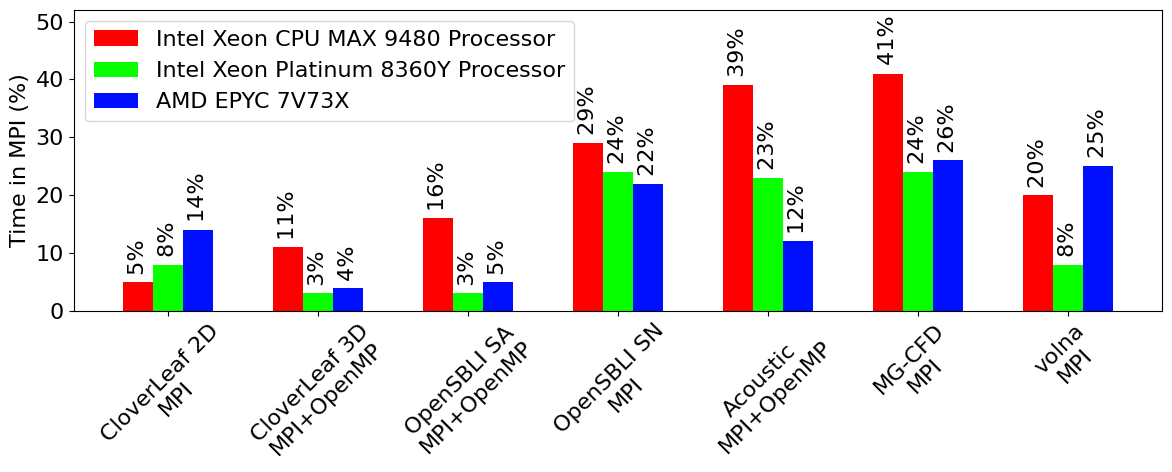

In [29]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert the data into a dictionary
data = {
    'SPR+HBM': {'CloverLeaf 2D\nMPI': 5, 'CloverLeaf 3D\nMPI+OpenMP': 11, 'OpenSBLI SA\nMPI+OpenMP': 16,
                'OpenSBLI SN\nMPI': 29, 'Acoustic\nMPI+OpenMP': 39, 'MG-CFD\nMPI': 41, 'volna\nMPI': 20},
    'ICX':     {'CloverLeaf 2D\nMPI': 8, 'CloverLeaf 3D\nMPI+OpenMP': 3, 'OpenSBLI SA\nMPI+OpenMP': 3,
                'OpenSBLI SN\nMPI': 24, 'Acoustic\nMPI+OpenMP': 23, 'MG-CFD\nMPI': 24, 'volna\nMPI': 8},
    'MilanX':  {'CloverLeaf 2D\nMPI': 14, 'CloverLeaf 3D\nMPI+OpenMP': 4, 'OpenSBLI SA\nMPI+OpenMP': 5,
                'OpenSBLI SN\nMPI': 22, 'Acoustic\nMPI+OpenMP': 12, 'MG-CFD\nMPI': 26, 'volna\nMPI': 25}
}

# Convert the dictionary into a dataframe
df_mpi = pd.DataFrame(data)

# Create a new figure
plt.figure(figsize=(12, 5))

# Get the current axes, creating them if necessary
ax = plt.gca()

bars_list = []
# Create the bars for each architecture
for i, arch in enumerate(df_mpi.columns):
    bars = ax.bar(np.arange(len(df_mpi.index)) + (i-1)*0.2, df_mpi[arch], width=0.2,
                  align='center', color=plt.cm.hsv(i / len(df_mpi.columns)))
    bars_list.append(bars)
    # Add data labels for each bar
    for rect in bars:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                f" {height}%", ha='center', va='bottom', rotation=90)

# Set labels and title
plt.ylabel('Time in MPI (%)')
# plt.xlabel('Applications')
plt.legend([bars[0] for bars in bars_list], ['Intel Xeon CPU MAX 9480 Processor', 'Intel Xeon Platinum 8360Y Processor', 'AMD EPYC 7V73X'], loc='upper left', fontsize='medium')
ax.set_ylim([0, 52])
#plt.title('Fraction of Time Spent in MPI Communications for Each Application on Each Architecture')

# Set the x-tick labels to the application names
ax.set_xticks(np.arange(len(df_mpi.index)))
ax.set_xticklabels(df_mpi.index, rotation=45)

plt.tight_layout()
plt.savefig('mpi.pdf', format='pdf',bbox_inches = 'tight')

plt.show()

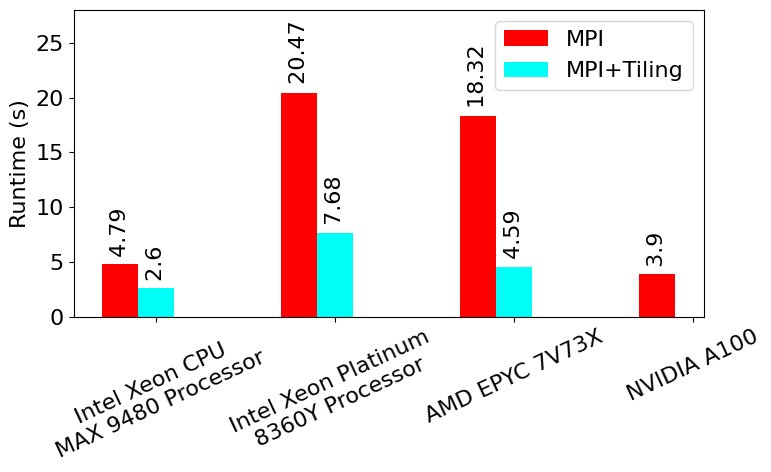

In [69]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert the data into a dictionary
data = {
    'MPI': {'Intel Xeon CPU\nMAX 9480 Processor': 4.79, 'Intel Xeon Platinum\n8360Y Processor': 20.47, 'AMD EPYC 7V73X': 18.32, 'NVIDIA A100': 3.90},
    'MPI+Tiling': {'Intel Xeon CPU\nMAX 9480 Processor': 2.60, 'Intel Xeon Platinum\n8360Y Processor': 7.68, 'AMD EPYC 7V73X': 4.59, 'NVIDIA A100': np.nan}
}

# Convert the dictionary into a dataframe
df_runtimes = pd.DataFrame(data)

# Create a new figure
plt.figure(figsize=(8, 5))

# Get the current axes, creating them if necessary
ax = plt.gca()

bars_list = []
# Create the bars for each implementation
for i, impl in enumerate(df_runtimes.columns):
    bars = ax.bar(np.arange(len(df_runtimes.index)) + (i-1)*0.2, df_runtimes[impl], width=0.2,
                  align='center', color=plt.cm.hsv(i / len(df_runtimes.columns)))
    bars_list.append(bars)

    # Add data labels for each bar
    for rect in bars:
        height = rect.get_height()
        if not np.isnan(height):  # Only add labels for non-nan values
            ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                    f" {height}", ha='center', va='bottom', rotation=90)

# Set labels and title
plt.ylabel('Runtime (s)')
#plt.xlabel('Architectures')
ax.set_ylim([0, 28])
#plt.title('Runtimes of CloverLeaf2D with Different Implementations on Each Architecture')

# Set the x-tick labels to the architecture names
ax.set_xticks(np.arange(len(df_runtimes.index)))
ax.set_xticklabels(df_runtimes.index, rotation=25)
plt.legend([bars[0] for bars in bars_list], df_runtimes.columns, loc='upper right', fontsize='medium')


plt.tight_layout()
plt.savefig('tiling.pdf', format='pdf',bbox_inches = 'tight')
plt.show()


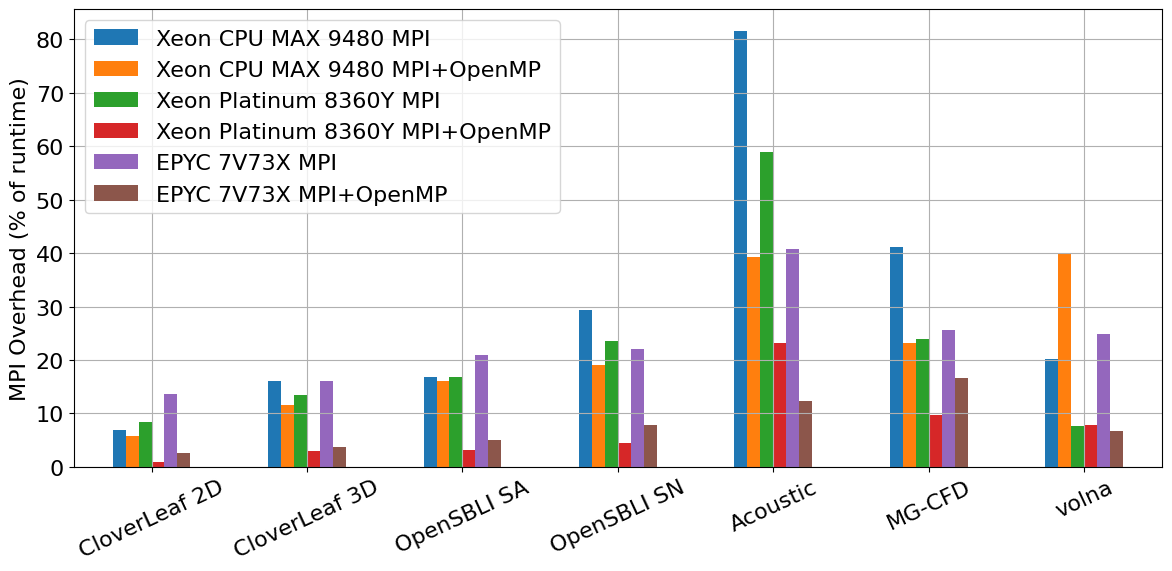

In [79]:
# Data
mpi_data = {
    "Application": ["CloverLeaf 2D", "CloverLeaf 3D", "OpenSBLI SA", "OpenSBLI SN", "Acoustic", "MG-CFD", "volna"],
    "Xeon CPU MAX 9480": [6.9, 16.0, 16.8, 29.3, 81.6, 41.2, 20.2],
    "Xeon Platinum 8360Y": [8.4, 13.4, 16.9, 23.6, 59.0, 23.9, 7.6],
    "EPYC 7V73X": [13.7, 16.1, 20.9, 22.0, 40.8, 25.6, 24.8]
}

mpi_openmp_data = {
    "Application": ["CloverLeaf 2D", "CloverLeaf 3D", "OpenSBLI SA", "OpenSBLI SN", "Acoustic", "MG-CFD", "volna"],
    "Xeon CPU MAX 9480": [5.8, 11.5, 16.1, 19.1, 39.3, 23.2, 39.9],
    "Xeon Platinum 8360Y": [0.9, 2.9, 3.1, 4.5, 23.2, 9.7, 7.9],
    "EPYC 7V73X": [2.5, 3.8, 5.0, 7.8, 12.3, 16.7, 6.7]
}

# Create dataframes
mpi_df = pd.DataFrame(mpi_data)
mpi_openmp_df = pd.DataFrame(mpi_openmp_data)

#plt.figure(figsize=(12, 5))

# Add suffixes to the columns to distinguish between MPI and MPI+OpenMP
mpi_df.columns = [col + " MPI" if col != "Application" else col for col in mpi_df.columns]
mpi_openmp_df.columns = [col + " MPI+OpenMP" if col != "Application" else col for col in mpi_openmp_df.columns]

# Merge the two dataframes
merged_df = pd.merge(mpi_df, mpi_openmp_df, on="Application")

# Reorder columns
ordered_columns = ["Application", "Xeon CPU MAX 9480 MPI", "Xeon CPU MAX 9480 MPI+OpenMP", "Xeon Platinum 8360Y MPI", "Xeon Platinum 8360Y MPI+OpenMP", "EPYC 7V73X MPI", "EPYC 7V73X MPI+OpenMP"]
merged_df = merged_df[ordered_columns]

# Create one combined plot for all three platforms with reordered columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.rcParams.update({'font.size': 16})

# Plot data
merged_df.plot(x="Application", kind="bar",  ax=ax)

# ax.set_title("Communications Overhead")
ax.set_ylabel("MPI Overhead (% of runtime)")
ax.set_xlabel("")
plt.xticks(rotation=25)
ax.grid(True)

# Set y-axis limit
#ax.set_ylim([0, max_y])
plt.savefig('mpi.pdf', format='pdf',bbox_inches = 'tight')

plt.tight_layout()
plt.show()